# Implementation of Variational AutoEncoder (VAE)

     VAE from "Auto-Encoding Variational Bayes" (2014, D.P. Kingma et. al.)
    
     Kernel-author: Jackson Kang @ Deep-learning Lab. (Handong Global University, S.Korea)
     
     Author-email:  mskang@handong.edu

     python and pytorch version: python=3.7, pytorch=1.3.1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt

In [11]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = False
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 100
latent_dim = 128
capacity = 32

lr = 1e-3

epochs = 200

nbr_datapoints = 5000

###    Step 1. Load (or download) Dataset

In [3]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

full_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_dataset = torch.utils.data.Subset(full_dataset, range(nbr_datapoints))
val_dataset = Subset(full_dataset, range(nbr_datapoints, nbr_datapoints*2))

print("Training dataset length:", len(train_dataset))
print("Validation dataset length:", len(val_dataset))

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)


Training dataset length: 5000
Validation dataset length: 5000


In [4]:
print(train_dataset[0][0].shape)

torch.Size([1, 28, 28])


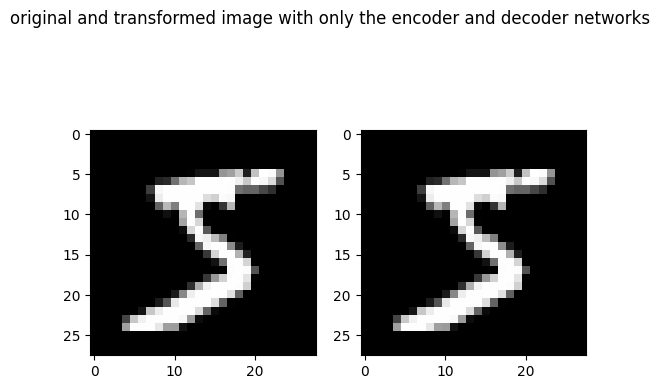

In [5]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(train_dataset[0][0][0,:,:], cmap='Greys_r')
ax[1].imshow(train_dataset[0][0][0,:,:], cmap='Greys_r')
plt.suptitle("original and transformed image with only the encoder and decoder networks")
plt.show()

### Step 2. Define our model: Variational AutoEncoder (VAE)

In [6]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()

        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c * 2, kernel_size=4, stride=2, padding=1)
        self.fc_mean = torch.nn.Linear(c * 2 * 7 * 7, latent_dim)
        self.fc_var = torch.nn.Linear(c * 2 * 7 * 7, latent_dim)
        
        self.training = True
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.2)
        x = x.view(x.size(0), -1)
        mean = self.fc_mean(x)
        log_var = self.fc_var(x)
        
        return mean, log_var

In [7]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()

        c = capacity
        self.fc1 = nn.Linear(in_features=latent_dim, out_features=c * 2 * 7 * 7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c * 2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        if x.dim() == 1:
            x = x.view(1, capacity * 2, 7, 7)
        else:
            x = x.view(x.size(0), capacity * 2, 7, 7)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.2)
        x = torch.sigmoid(self.conv1(x))
        return x
        

In [8]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [9]:
encoder = Encoder(latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [10]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    #print(x_hat.shape)
    #print(x.shape)
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Variational AutoEncoder (VAE)

In [12]:
print("Start training VAE...")
model.train()

train_loss = []
val_loss = []

for epoch in range(epochs):
    overall_loss = 0
    overall_loss_val = 0

    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, 1, 28, 28)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()

    for batch_idx, (x, _) in enumerate(val_loader):
        x = x.view(batch_size, 1, 28, 28)
        x = x.to(DEVICE)

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss_val += loss.item()

    train_loss.append(overall_loss/ (batch_idx*batch_size))
    val_loss.append(overall_loss_val/ (batch_idx*batch_size))
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size), "\tAverage Loss Val: ", overall_loss_val / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  287.04717354910713 	Average Loss Val:  200.8663743622449
	Epoch 2 complete! 	Average Loss:  186.62278659119897 	Average Loss Val:  175.63196508290815
	Epoch 3 complete! 	Average Loss:  168.13328603316327 	Average Loss Val:  163.0274172911352
	Epoch 4 complete! 	Average Loss:  158.63068060427295 	Average Loss Val:  154.73413723692602
	Epoch 5 complete! 	Average Loss:  151.36855329241072 	Average Loss Val:  148.73516163105867
	Epoch 6 complete! 	Average Loss:  146.12337213010204 	Average Loss Val:  144.0914582669005
	Epoch 7 complete! 	Average Loss:  141.11432059151787 	Average Loss Val:  140.02837990274236
	Epoch 8 complete! 	Average Loss:  136.93858418367347 	Average Loss Val:  135.3821027981505
	Epoch 9 complete! 	Average Loss:  132.5846789301658 	Average Loss Val:  132.26193857621175
	Epoch 10 complete! 	Average Loss:  129.5921008051658 	Average Loss Val:  129.39049445950255
	Epoch 11 complete! 	Average Loss:  126.6943680245535

In [13]:
#save the model

torch.save(model.state_dict(), './models/VAE_0001LR_200epo_5kN_100BS_CNN_archi_with_valCurve.pth')

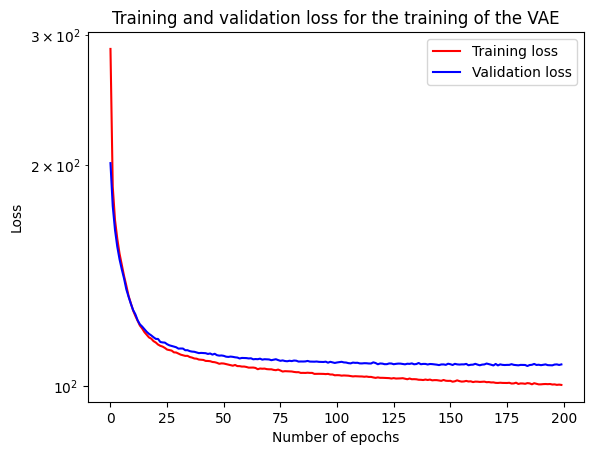

In [19]:
plt.semilogy(train_loss, color = "red", label = "Training loss")
plt.semilogy(val_loss, color = "blue", label = "Validation loss")

plt.xlabel("Number of epochs")
plt.ylabel("Loss (log-scale)")

#plt.yscale("log")

plt.title("Training and validation loss for the training of the VAE")

plt.legend()

plt.show()

In [ ]:
#load the model

# Instantiate your model
#model = MyModel()

# Load the saved model state dictionary
#model.load_state_dict(torch.load('my_model.pth'))


### Functions for the adversarial attack

In [16]:
#Algorithm coming from the paper of Sun
#define the loss function to generate the adversarial image

def loss_function(x_ori, x, lam, type1 = True):
    """ 
    Loss function to generate the adversarial image where input different and output same. (type 1 attack)
    Loss function to generate the adversarial image where input similar and output different. (type 2 attack) 
    """
    x_back = model(x)
    
    x_back = x_back[0] #get the tensor in first position of the tuple
    #print(x_back)
    #print(x_back.shape)
    #print(type(x_back))

    my_loss = torch.linalg.vector_norm(x_back-x_ori) - lam * torch.linalg.vector_norm(x-x_ori)  #torch.linalg.vector_norm

    if(not type1):
        my_loss = -1*my_loss #change sign of the loss function in case type 2 attack

    return my_loss

def loss_function_target(x_ori, x_target, x, lam):
    """ Loss function to generate the adversarial image where input similar and output different and equal to a target image. (type 2 attack) """
    
    x_back = model(x)
    #x_back = net3(net1(x))
    my_loss = torch.linalg.vector_norm(x_back-x_target) + lam * torch.linalg.vector_norm(x-x_ori)  #torch.linalg.vector_norm

    return my_loss

def adversarial_attack(adv_image_ori, nbr_it, lam_fun, eta_fun, type1):
    """
    Adversarial attack using algorithm from the paper of Sun (type 1 attack)

    adv_image_ori = original unperturbed image
    adv_image = image that will be perturbed
    nbr_it = number of iterations
    lam_fun = lambda value = trade-off between the two terms
    eta = rate to apply the perturbation on the image, "learning rate"
    type1 = chose between type 1 and type 2 attack
    """

    #initialize the adversarial image that will be perturbed
    adv_image = torch.tensor(adv_image_ori, requires_grad=True)

    #attack on the image
    for i in range(nbr_it):   
        adv_image = adv_image.clone().detach().requires_grad_(True)
        loss_value = loss_function(adv_image_ori, adv_image, lam_fun, type1)
        loss_value.backward() #1.0
        adv_image = adv_image - eta_fun*adv_image.grad
        torch.clamp(adv_image, 0, 1) #clamp all values between 0 and 1

        #if((i+1)%1==0):
        #    similarity_input.append(similarity_images(adv_image_ori, adv_image))
        #    similarity_output.append(similarity_images(generate_back(adv_image, U, V, s, h), adv_image))
    
    return adv_image

def adversarial_attack_target(adv_image_ori, x_target, nbr_it, lam_fun, eta_fun):
    """
    Adversarial attack using algorithm from the paper of Sun (type 1 attack)

    adv_image_ori = original unperturbed image
    adv_image = image that will be perturbed
    x_target = target image to which we want that the output of the adversarial image is equal
    nbr_it = number of iterations
    lam_fun = lambda value = trade-off between the two terms
    eta = rate to apply the perturbation on the image, "learning rate"
    """

    #initialize the adversarial image that will be perturbed
    adv_image = torch.tensor(adv_image_ori, requires_grad=True)

    #attack on the image
    for i in range(nbr_it):   
        adv_image = adv_image.clone().detach().requires_grad_(True)
        loss_value = loss_function_target(adv_image_ori, x_target, adv_image, lam_fun)
        loss_value.backward() #1.0
        adv_image = adv_image - eta_fun*adv_image.grad
        torch.clamp(adv_image, 0, 1) #clamp all values between 0 and 1

        #if((i+1)%1==0):
        #    similarity_input.append(similarity_images(adv_image_ori, adv_image))
        #    similarity_output.append(similarity_images(generate_back(adv_image, U, V, s, h), adv_image))
            #similarity_output.append(similarity_images(net3(net1(adv_image)), adv_image))
    return adv_image

In [17]:
#hyperparameters for the attack
my_lambda = 0.1 #10 for type 1 attack, and 0.1 for type 2 and target  #trade-off between similarity input/output and difference output/input (depending on attack 1 or 2)
nbr_iterations = 100 #iterations to compute the perturbation
eta = 0.1 #learning rate, proportion of the gradient added to the image


In [18]:
image_original = train_dataset[0][0][0,:,:].clone().detach()

print(image_original.shape)

torch.Size([28, 28])


In [19]:
image_original = image_original.view(1,1,28,28)
#image_original = image_original.clone().detach().requires_grad_(True)

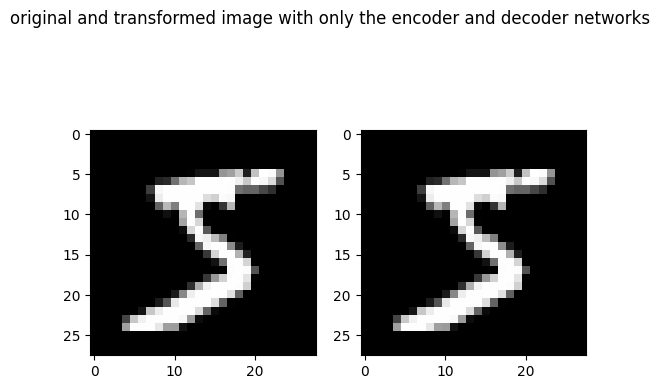

In [20]:
#plot images
fig, ax = plt.subplots(1, 2)
ax[0].imshow(train_dataset[0][0][0,:,:], cmap='Greys_r')
ax[1].imshow(train_dataset[0][0][0,:,:], cmap='Greys_r')
plt.suptitle("original and transformed image with only the encoder and decoder networks")
plt.show()

In [21]:
image_adv = adversarial_attack(image_original, nbr_iterations, my_lambda, eta, type1=False)
#image_adv = adversarial_attack_target(image_adv_ori, image_target, nbr_iterations, my_lambda, eta)

C:\Users\gcorl\AppData\Local\Temp\ipykernel_10348\1970186158.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adv_image = torch.tensor(adv_image_ori, requires_grad=True)


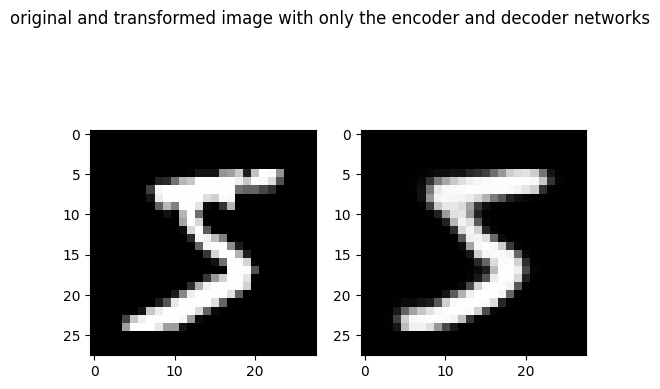

In [22]:
image_original_back = model(image_original)

#plot images
fig, ax = plt.subplots(1, 2)
ax[0].imshow(train_dataset[0][0][0,:,:], cmap='Greys_r')
ax[1].imshow(image_original_back[0].view(28, 28).detach().numpy(), cmap='Greys_r')
plt.suptitle("original and transformed image with only the encoder and decoder networks")
plt.show()

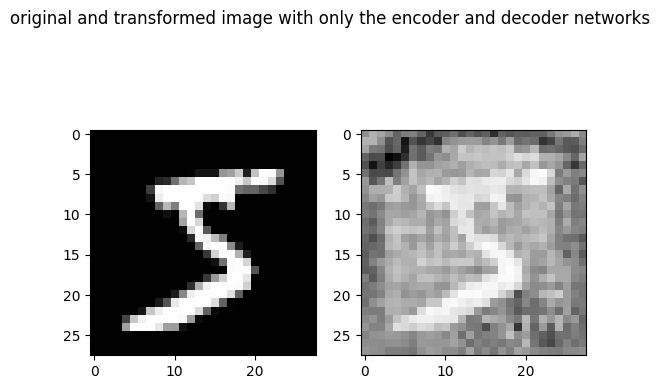

In [23]:
#plot images
fig, ax = plt.subplots(1, 2)
ax[0].imshow(train_dataset[0][0][0,:,:], cmap='Greys_r')
ax[1].imshow(image_adv[0].view(28, 28).detach().numpy(), cmap='Greys_r')
plt.suptitle("original and transformed image with only the encoder and decoder networks")
plt.show()

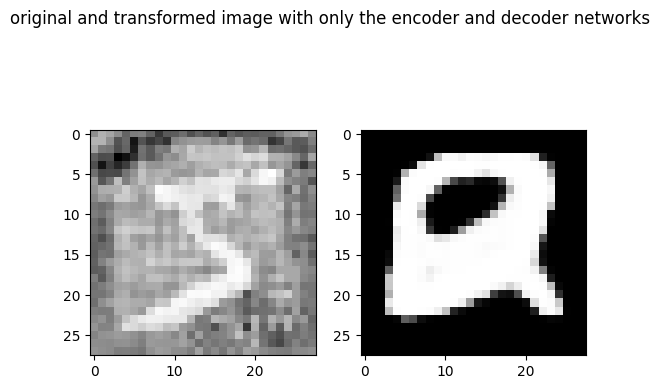

In [24]:
image_adv_back = model(image_adv)

#plot images
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_adv[0].view(28, 28).detach().numpy(), cmap='Greys_r')
ax[1].imshow(image_adv_back[0].view(28, 28).detach().numpy(), cmap='Greys_r')
plt.suptitle("original and transformed image with only the encoder and decoder networks")
plt.show()

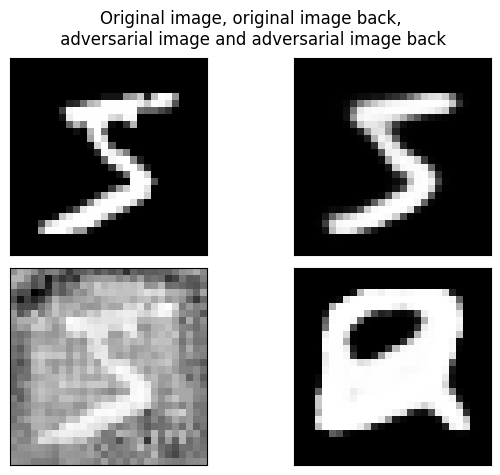

In [26]:
fig, ax = plt.subplots(2, 2)
ax[0,0].imshow(train_dataset[0][0][0,:,:], cmap='Greys_r')
ax[0,1].imshow(image_original_back[0].view(28, 28).detach().numpy(), cmap='Greys_r')
ax[1,0].imshow(image_adv[0].view(28, 28).detach().numpy(), cmap='Greys_r')
ax[1,1].imshow(image_adv_back[0].view(28, 28).detach().numpy(), cmap='Greys_r')
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.suptitle("Original image, original image back,\n adversarial image and adversarial image back")
plt.savefig("./images/att2_VAE_100epo_0001LR_60kN_new_archi.png")
plt.show()

### Step 5. Generate images from test dataset

In [30]:
import matplotlib.pyplot as plt

In [31]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)


        break

  0%|          | 0/100 [00:05<?, ?it/s]


In [37]:
def show_image(x, idx):
    print(x.shape)
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

torch.Size([100, 784])


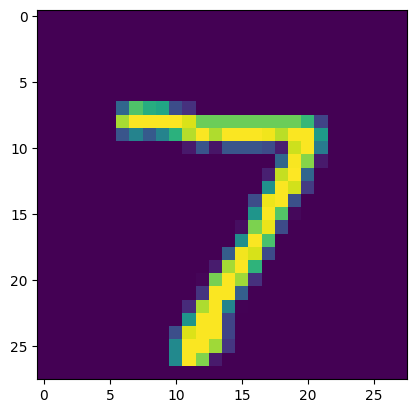

In [38]:
show_image(x, idx=0)

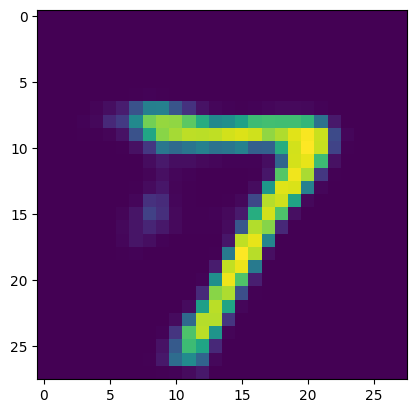

In [34]:
show_image(x_hat, idx=0)

### Step 6. Generate image from noise vector

**Please note that this is not the correct generative process.**

* Even if we don't know exact p(z|x), we can generate images from noise, since the loss function of training VAE regulates the q(z|x) (simple and tractable posteriors) must close enough to N(0, I). If q(z|x) is close to N(0, I) "enough"(but not tightly close due to posterior collapse problem), N(0, I) may replace the encoder of VAE.

* To show this, I just tested with a noise vector sampled from N(0, I) similar with Generative Adversarial Network.

In [15]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

In [16]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

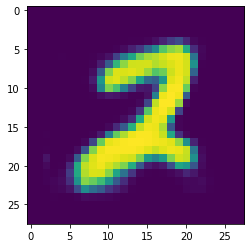

In [17]:
show_image(generated_images, idx=12)

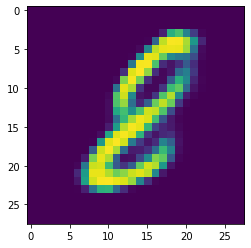

In [18]:
show_image(generated_images, idx=0)

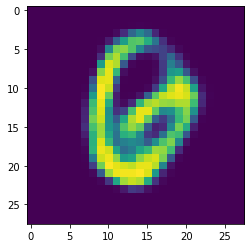

In [19]:
show_image(generated_images, idx=1)

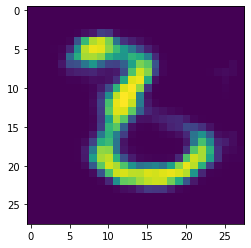

In [20]:
show_image(generated_images, idx=10)

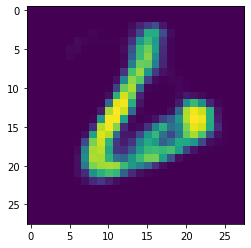

In [21]:
show_image(generated_images, idx=20)

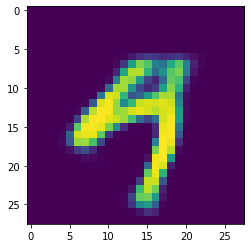

In [22]:
show_image(generated_images, idx=50)